In [31]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
dirs = os.listdir('./runs/')
df_model = pd.DataFrame()
df_real = pd.DataFrame()
df_model_random = pd.DataFrame()

for dir in dirs:
    files = os.listdir(f'./runs/{dir}')
    model_path = [f'./runs/{dir}/{f}' for f in files if f.endswith('.json') and 'model_output' in f]
    real_path = [f'./runs/{dir}/{f}' for f in files if f.endswith('.json') and 'real_output' in f]
    random_path = [f'./runs/{dir}/{f}' for f in files if f.endswith('.json') and 'model_random_output' in f]
    
    df_model_aux = pd.read_json(model_path[0])
    df_real_aux = pd.read_json(real_path[0])
    df_random_aux = pd.read_json(random_path[0])

    df_model_aux['algorithm'] = dir
    df_real_aux['algorithm'] = dir
    df_random_aux['algorithm'] = dir

    df_model_aux = df_model_aux[df_model_aux['data'].notna()][['data', 'algorithm']]
    df_real_aux = df_real_aux[df_real_aux['data'].notna()][['data', 'algorithm']]
    df_random_aux = df_random_aux[df_random_aux['data'].notna()][['data', 'algorithm']]

    df_model = pd.concat([df_model, df_model_aux])
    df_real = pd.concat([df_real, df_real_aux])
    df_model_random = pd.concat([df_model_random, df_random_aux])

In [43]:
df_model['data'] = df_model['data'].apply(lambda x: x if x['start_time'] != 0 else None)
df_model = df_model.dropna()

df_model_random['data'] = df_model_random['data'].apply(lambda x: x if x['start_time'] != 0 else None)
df_model_random = df_model_random.dropna()

In [44]:
df_model['exec_time'] = df_model['data'].apply(lambda x: x['stop_time'] - x['start_time'])
df_real['exec_time'] = df_real['data'].apply(lambda x: x['stop_time'] - x['start_time'])
df_model_random['exec_time'] = df_model_random['data'].apply(lambda x: x['stop_time'] - x['start_time'])

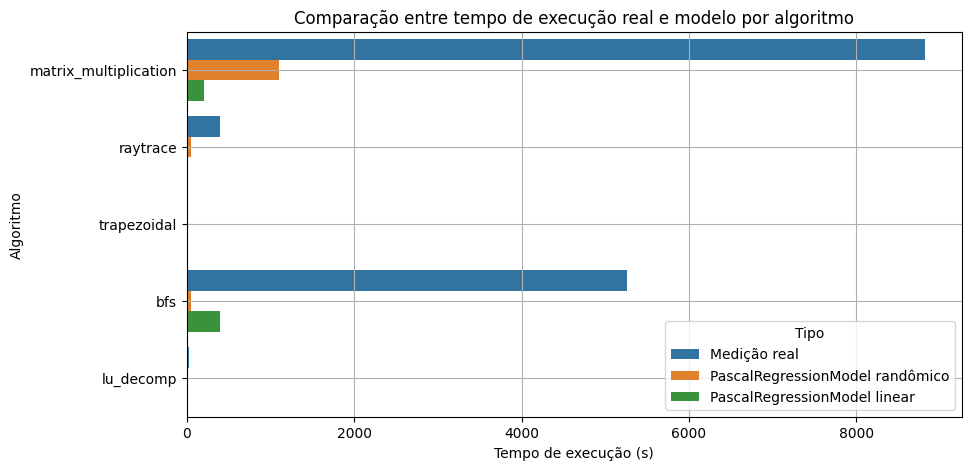

In [63]:
algorithms = df_real['algorithm'].unique()
data = []
for algo in algorithms:
    data.append({'Algoritmo': algo, 'Tipo': 'Medição real', 'Tempo': df_real[df_real['algorithm'] == algo]['exec_time'].sum()})
    data.append({'Algoritmo': algo, 'Tipo': 'PascalRegressionModel randômico', 'Tempo': df_model_random[df_model_random['algorithm'] == algo]['exec_time'].sum()})
    data.append({'Algoritmo': algo, 'Tipo': 'PascalRegressionModel linear', 'Tempo': df_model[df_model['algorithm'] == algo]['exec_time'].sum()})

df = pd.DataFrame(data)

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df, y='Algoritmo', x='Tempo', hue='Tipo', orient='h')

plt.ylabel('Algoritmo')
plt.xlabel('Tempo de execução (s)')
plt.title('Comparação entre tempo de execução real e modelo por algoritmo')
plt.legend(title='Tipo', loc='lower right')
plt.grid()
plt.show()